# Import and Download dataset

In [1]:
import kagglehub

data_dir = kagglehub.dataset_download(
    'andrewmvd/dog-and-cat-detection',
)
print('Path to dataset files:', data_dir)

c:\Users\Admin\anaconda3\envs\aio2024-hw\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Admin\.cache\kagglehub\datasets\andrewmvd\dog-and-cat-detection\versions\1


In [2]:
import torch.backends.cudnn as cudnn
cudnn.benchmark = False
cudnn.deterministic = True
cudnn.enabled = False

In [3]:
import os
import torch
import time
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET

from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights
from torch.cuda.amp import GradScaler, autocast

In [4]:
import sys
sys.path.append('../..')
from utils.memory_tracker import MemoryTracker, safe_to_device

In [5]:
class ImageDataset(Dataset):
    def __init__(
        self,
        annotations_dir,
        image_dir,
        transform=None,
    ):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = self.filter_images_with_multiple_objects()
        
    def filter_images_with_multiple_objects(self):
        valid_image_files = []
        for f in os.listdir(self.image_dir):
            if not os.path.isfile(os.path.join(self.image_dir, f)):
                continue
            img_name = f
            annotation_name = os.path.splitext(img_name)[0] + '.xml'
            annotation_path = os.path.join(self.annotations_dir, annotation_name)
            
            if self.count_objects_in_annotation(annotation_path) <= 1:
                valid_image_files.append(img_name)
            else:
                print(f'Image {img_name} has multiple objects and will be excluded from the dataset')
        return valid_image_files
    
    def count_objects_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for _ in root.findall('object'):
                count += 1
            return count
        except FileNotFoundError:
            return 0
        
    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        
        img_width = int(root.find('size/width').text)
        img_height = int(root.find('size/height').text)
        
        label = None
        bbox = None
        for obj in root.findall('object'):
            name = obj.find('name').text
            if not label:
                label = name
                xmin = int(obj.find('bndbox/xmin').text)
                ymin = int(obj.find('bndbox/ymin').text)
                xmax = int(obj.find('bndbox/xmax').text)
                ymax = int(obj.find('bndbox/ymax').text)
                
                bbox = [
                    xmin / img_width,
                    ymin / img_height,
                    xmax / img_width,
                    ymax / img_height,
                ]
                
        label_num = 0 if label == 'cat' else 1 if label == 'dog' else -1
        return label_num, torch.tensor(bbox, dtype=torch.float32)
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        image = Image.open(img_path).convert('RGB')
        
        annotation_name = os.path.splitext(img_name)[0] + '.xml'
        annotation_path = os.path.join(self.annotations_dir, annotation_name)
        
        label, bbox = self.parse_annotation(annotation_path)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label, bbox

In [6]:
annotations_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
df = pd.DataFrame({'image_name': image_files})

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
df

,image_name
0,Cats_Test0.png
1,Cats_Test1.png
2,Cats_Test10.png
3,Cats_Test100.png
4,Cats_Test1000.png
...,...
3681,Cats_Test995.png
3682,Cats_Test996.png
3683,Cats_Test997.png
3684,Cats_Test998.png


# Prepare dataset

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

train_dataset = ImageDataset(annotations_dir, image_dir, transform)
val_dataset = ImageDataset(annotations_dir, image_dir, transform)

train_dataset.image_files = [f for f in train_dataset.image_files if f in train_df['image_name'].values]
val_dataset.image_files = [f for f in val_dataset.image_files if f in val_df['image_name'].values]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

Image Cats_Test736.png has multiple objects and will be excluded from the dataset
Image Cats_Test736.png has multiple objects and will be excluded from the dataset


# Model

In [8]:
class TwoHeadedModel(nn.Module):
    def __init__(self, num_classes=2):
        super(TwoHeadedModel, self).__init__()
        self.base_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.num_ftrs = self.base_model.fc.in_features
        
        # Remove the original fully connected layer
        self.base_model.fc = nn.Identity()
        
        # Classification head
        self.classifier = nn.Linear(self.num_ftrs, num_classes)
        
        # Bounding box regression head
        self.regressor = nn.Linear(self.num_ftrs, 4)
        
    def forward(self, x):
        x = self.base_model(x)
        class_logits = self.classifier(x)
        bbox_coords = torch.sigmoid(self.regressor(x))
        
        return class_logits, bbox_coords

In [9]:
from typing import Tuple, Dict, List

def train(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    criterion_class: torch.nn.Module,
    criterion_bbox: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    scaler: torch.amp.GradScaler,
    device: torch.device,
    desc: str = 'Training',
    position: int = 1,
) -> Tuple[float, float]:
    model.train()
    total_loss = total_acc = total_count = 0
    
    try:        
        with tqdm(
            dataloader,
            desc=desc,
            unit='batch',
            total=len(dataloader),
            position=position,
            leave=True,
        ) as pbar:
            for batch_idx, (data, targets, bboxes) in enumerate(pbar):
                try:
                    optimizer.zero_grad()
                    
                    with autocast(device, dtype=torch.float16):
                        scores, pred_bboxes = model(data)
                        loss_class = criterion_class(scores, targets)
                        loss_bbox = criterion_bbox(pred_bboxes, bboxes)
                        loss = loss_class + loss_bbox
                    
                    # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
                    # Backward passes under autocast are not recommended.
                    # Backward ops run in the same dtype autocast chose for corresponding forward ops.
                    scaler.scale(loss).backward()

                    # scaler.step() first unscales the gradients of the optimizer's assigned params.
                    # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
                    # otherwise, optimizer.step() is skipped.
                    scaler.step(optimizer)

                    # Updates the scale for next iteration.
                    scaler.update()
                    
                    total_loss += float(loss.detach().item() * targets.size(0))
                    _, predictions = scores.max(1)
                    total_acc += (predictions == targets).sum().item()
                    total_count += scores.size(0)
                    
                    del data, targets, scores, predictions
                except RuntimeError as e:
                    print(f"\nError in training batch {batch_idx}: {str(e)}")
                    optimizer.zero_grad()
                    continue
                
                allocated, reserved = MemoryTracker.get_memory_stats()
                pbar.set_postfix({
                    'Loss': f'{total_loss/max(1, total_count):.4f}',
                    'Acc': f'{100.*total_acc/max(1, total_count):.4f}%',
                    'Allocated GPU': f'{allocated:.2f}MB',
                    'Reserved GPU': f'{reserved:.2f}MB'
                })
    except Exception as e:
        print(f"\nTraining error: {str(e)}")
        MemoryTracker.clear_memory(model)
        raise

    epoch_loss = total_loss / max(1, total_count)
    epoch_acc = total_acc / max(1, total_count)
    
    return epoch_acc, epoch_loss

def eval(
    model: torch.nn.Module,
    criterion_class: torch.nn.Module,
    criterion_bbox: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device: torch.device,
    desc: str = 'Validating',
    position: int = 1,
    is_leaving = False
) -> Tuple[float, float]:
    model.eval()
    total_loss_bbox = total_acc = total_count = 0
    
    try:  
        with tqdm(
            dataloader,
            desc=desc,
            unit='sample',
            unit_scale=dataloader.batch_size,
            position=position,
            leave=is_leaving,
        ) as pbar:
            for batch_idx, (data, targets, bboxes) in enumerate(pbar):
                try:
                    data = safe_to_device(data, device)
                    targets = safe_to_device(targets, device)
                    bboxes = safe_to_device(bboxes, device)
                    
                    scores, pred_bboxes = model(data)
                    _, predictions = scores.max(1)
                    loss_bbox = criterion_bbox(pred_bboxes, bboxes)
                    
                    total_loss_bbox += float(loss_bbox.detach().item() * targets.size(0))
                    _, predictions = scores.max(1)
                    total_acc += (predictions == targets).sum().item()
                    total_count += scores.size(0)
                    
                    del data, targets, scores, predictions
                except RuntimeError as e:
                    print(f"\nError in training batch {batch_idx}: {str(e)}")
                    continue
                
                allocated, reserved = MemoryTracker.get_memory_stats()
                pbar.set_postfix({
                    'Loss BBOX': f'{total_loss_bbox/max(1, total_count):.4f}',
                    'Acc': f'{100.*total_acc/max(1, total_count):.4f}%',
                    'Allocated GPU': f'{allocated:.2f}MB',
                    'Reserved GPU': f'{reserved:.2f}MB'
                })
    except Exception as e:
        print(f"\nTraining error: {str(e)}")
        MemoryTracker.clear_memory(model)
        raise

    epoch_loss = total_loss_bbox / max(1, total_count)
    epoch_acc = total_acc / max(1, total_count)
    
    return epoch_acc, epoch_loss

In [10]:
def fit(
    model: torch.nn.Module,
    criterion_class: torch.nn.Module,
    criterion_bbox: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    device: torch.device,
    epochs: int,
) -> Dict[str, List[float]]:
    history = {
        'train_acc': [], 'train_loss': [],
        'val_acc': [], 'val_loss': [],
        'epoch_times': [], 'gpu_allocated': [], 'gpu_reserved': []
    }
    try:
        scaler = GradScaler()
        
        with tqdm(range(epochs), desc="Epochs", position=0, leave=True) as epoch_pbar:
            for epoch in epoch_pbar:
                try:
                    epoch_start = time.time()

                    train_acc, train_loss = train(
                        model, optimizer, criterion_class,
                        criterion_bbox, train_loader, scaler, device,
                        desc=f"Epoch {epoch+1}/{epochs} [Train]",
                        position=0,
                    )

                    val_acc, val_loss = eval(
                        model, criterion_class,
                        criterion_bbox, val_loader, device,
                        desc=f"Epoch {epoch+1}/{epochs} [Val]",
                        position=0,
                        is_leaving=True,
                    )

                    epoch_time = time.time() - epoch_start
                    allocated, reserved = MemoryTracker.get_memory_stats()

                    history['train_acc'].append(train_acc)
                    history['train_loss'].append(train_loss)
                    history['val_acc'].append(val_acc)
                    history['val_loss'].append(val_loss)
                    history['epoch_times'].append(epoch_time)
                    history['gpu_allocated'].append(allocated)
                    history['gpu_reserved'].append(reserved)

                except Exception as e:
                    print(f"\nError in epoch {epoch + 1}: {str(e)}")
                    MemoryTracker.clear_memory(model)
                    continue
    
    except Exception as e:
        print(f"\nTraining loop error: {str(e)}")
        MemoryTracker.clear_memory(model)

    return history

In [11]:
num_epochs = 10

model = TwoHeadedModel()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = safe_to_device(model, device)

criterion_class = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

history = fit(
    model,
    criterion_class,
    criterion_bbox,
    optimizer,
    train_loader,
    val_loader,
    device,
    num_epochs,
)
    

c:\Users\Admin\anaconda3\envs\aio2024-hw\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


TwoHeadedModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

Epoch 1/10 [Train]:   0%|          | 0/93 [00:00<?, ?batch/s]c:\Users\Admin\anaconda3\envs\aio2024-hw\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epochs: 100%|██████████| 10/10 [1:21:29<00:00, 488.96s/it]


In [12]:
max_memory = max(history['gpu_allocated'])
print(f"Peak GPU memory usage: {max_memory:.2f} MB")

Peak GPU memory usage: 0.00 MB


# Visualize prediction

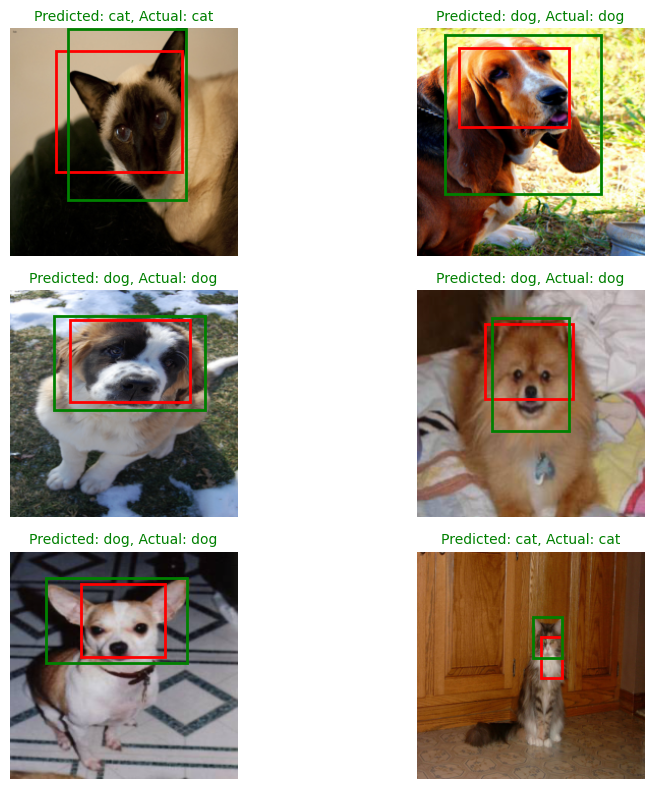

In [13]:
def visualize_predictions_with_bbox(model, dataloader, num_images=6, device='cpu'):
    model.eval()
    imgs_so_far = 0
    class_names = ['cat', 'dog']
    fig = plt.figure(figsize=(10, 8))
    
    with torch.no_grad():
        for i, (images, labels, bboxes) in enumerate(dataloader):
            images = safe_to_device(images, device)
            labels = safe_to_device(labels, device)
            
            class_outputs, bbox_outputs = model(images)
            _, preds = torch.max(class_outputs, 1)
            
            for j in range(images.size()[0]):
                imgs_so_far += 1
                ax = plt.subplot(num_images // 2, 2, imgs_so_far)
                ax.axis('off')
                
                # Denormalize and display the image
                img = images.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = [0.485, 0.456, 0.406]
                std = [0.229, 0.224, 0.225]
                img = std * img + mean
                img = np.clip(img, 0, 1)  # Clip values to be between 0 and 1
                ax.imshow(img)

                # Get predicted bounding box coordinates
                pred_bbox = bbox_outputs[j].cpu().numpy()
                x_min, y_min, x_max, y_max = pred_bbox

                # Scale bounding box coordinates back to image size
                x_min = int(x_min * img.shape[1])
                y_min = int(y_min * img.shape[0])
                x_max = int(x_max * img.shape[1])
                y_max = int(y_max * img.shape[0])

                # Draw the bounding box on the image
                rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

                # Get ground truth bounding box coordinates
                gt_bbox = bboxes[j].cpu().numpy()
                gt_x_min, gt_y_min, gt_x_max, gt_y_max = gt_bbox

                # Scale ground truth bounding box coordinates back to image size
                gt_x_min = int(gt_x_min * img.shape[1])
                gt_y_min = int(gt_y_min * img.shape[0])
                gt_x_max = int(gt_x_max * img.shape[1])
                gt_y_max = int(gt_y_max * img.shape[0])

                # Draw the ground truth bounding box on the image
                gt_rect = patches.Rectangle((gt_x_min, gt_y_min), gt_x_max - gt_x_min, gt_y_max - gt_y_min, linewidth=2, edgecolor='g', facecolor='none')
                ax.add_patch(gt_rect)

                ax.set_title(
                    f"Predicted: {class_names[preds[j]]}, Actual: {class_names[labels[j]]}",
                    fontdict={
                        "fontsize": 10,
                        "color": "green" if preds[j] == labels[j] else "red",
                    },
                )

                if imgs_so_far == num_images:
                    plt.tight_layout()
                    plt.show()
                    return
                
# Visualize some predictions
visualize_predictions_with_bbox(model, val_loader, device=device)  